# Overfitting, Overparameterization, and Double-Descent

## Abstract

This notebook explores the phenomenon of double descent in machine learning, where test error decreases, then increases, and finally decreases again as model complexity increases. This counterintuitive pattern challenges the classical understanding of overfitting and the bias-variance tradeoff. Using overparameterized linear regression with random features, we demonstrate how models with more parameters than training samples can actually generalize better than their "appropriately parameterized" counterparts.

We implement a linear regression model using the pseudoinverse approach to handle overparameterization, apply it to both synthetic data and an image corruption detection task, and visualize the double descent curve. Our results provide empirical evidence that the relationship between model complexity and generalization is more nuanced than traditionally understood.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8-whitegrid')

## Feature Map Implementation

In [2]:
def sig(x): 
    return 1/(1+torch.exp(-x))

def square(x): 
    return x**2

class RandomFeatures:
    """
    Random feature map. This feature map must be "fit" before use.
    
    For each data point x_i, the j-th feature is constructed as σ(⟨ω_j, x_i⟩ + b_j),
    where σ is the activation function and ω_j and b_j are generated randomly.
    
    Example usage:
    phi = RandomFeatures(n_features=10)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)
    """
    def __init__(self, n_features=10, activation=sig):
        self.n_features = n_features
        self.u = None
        self.b = None
        self.activation = activation

    def fit(self, X):
        """Initialize random weights and biases for the feature map"""
        self.u = torch.randn((X.size()[1], self.n_features), dtype=torch.float64)
        self.b = torch.rand((self.n_features), dtype=torch.float64) 

    def transform(self, X):
        """Apply the feature map to input data"""
        return self.activation(X @ self.u + self.b)

This RandomFeatures class implements a flexible feature map that applies a nonlinear activation function to random projections of our input data. The feature map transforms our original data into a higher-dimensional space where linear patterns might better capture nonlinear relationships in the original data. We'll use this feature map extensively throughout our experiments.

## Part 0

The standard formula for the optimal weight vector in unregularized least-squares linear regression is:

$$\hat{w} = (X^TX)^{-1}X^Ty$$

This formula has a closed-form solution only when the number of data observations $n$ is larger than the number of features $p$. When $p > n$, the matrix $X^TX$ becomes singular (not invertible).

The issue occurs for the following mathematical reasons:
- The rank of $X^TX$ is at most $\min(n,p)$
- When $p > n$, the matrix has at most rank $n$, but it's a $p \times p$ matrix
- This means it has linearly dependent columns
- The matrix inversion operation $(X^TX)^{-1}$ is not defined for singular matrices

Therefore, the standard formula breaks down when we have more features than data points.

## Part A: Implementing Overparameterized Linear Regression

We'll implement a linear regression model that can handle the overparameterized case using the Moore-Penrose pseudoinverse.

In [3]:
class LinearModel:
    """Base class for linear models"""
    def __init__(self):
        self.w = None
    
    def score(self, X):
        """Compute score for each data point"""
        if self.w is None:
            self.w = torch.rand((X.size()[1]), dtype=torch.float64)
        return X @ self.w
    
    def predict(self, X):
        """Simply returns the score for regression"""
        return self.score(X)

Building on our base LinearModel, we'll now create a more specific implementation for regression that includes a method to calculate the mean squared error loss. This will help us evaluate our model's performance.

In [4]:
class MyLinearRegression(LinearModel):
    """Linear regression model for regression problems"""
    def __init__(self):
        super().__init__()
    
    def predict(self, X):
        """Return the score for regression problem"""
        return self.score(X)
    
    def loss(self, X, y):
        """Compute mean squared error loss"""
        y_pred = self.predict(X)
        return ((y_pred - y)**2).mean()

The key component of our implementation is the optimizer that can handle overparameterized scenarios. Unlike traditional linear regression which breaks down when there are more features than samples, our implementation will use the pseudoinverse to find a solution even in these cases.

In [5]:
class OverParameterizedLinearRegressionOptimizer:
    """Optimizer for overparameterized linear regression"""
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        """
        Compute optimal weights using the pseudoinverse formula:
        w_hat = X^+ y
        
        In the overparameterized case, X^+ = X^T(XX^T)^(-1),
        but we'll use torch's built-in pinv function for numerical stability.
        """
        # Using torch's pseudoinverse function to compute X^+
        X_plus = torch.linalg.pinv(X)
        
        # Set the model weights using the pseudoinverse formula
        self.model.w = X_plus @ y
        
        return self.model

## Part B: Testing the Model on Simple Data

Let's create a simple 1D dataset with a nonlinear pattern to test our implementation. We'll generate points along the x-axis and compute a 4th degree polynomial with some added noise. This will give us a challenging regression problem to solve.

In [6]:
# Generate synthetic data
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype=torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

To tackle this nonlinear pattern, we'll apply our random feature map with a square activation function. This will transform our 1D data into a higher-dimensional space where a linear model can better capture the underlying pattern. We'll visualize both the original data and our model's predictions to see how well it performs.

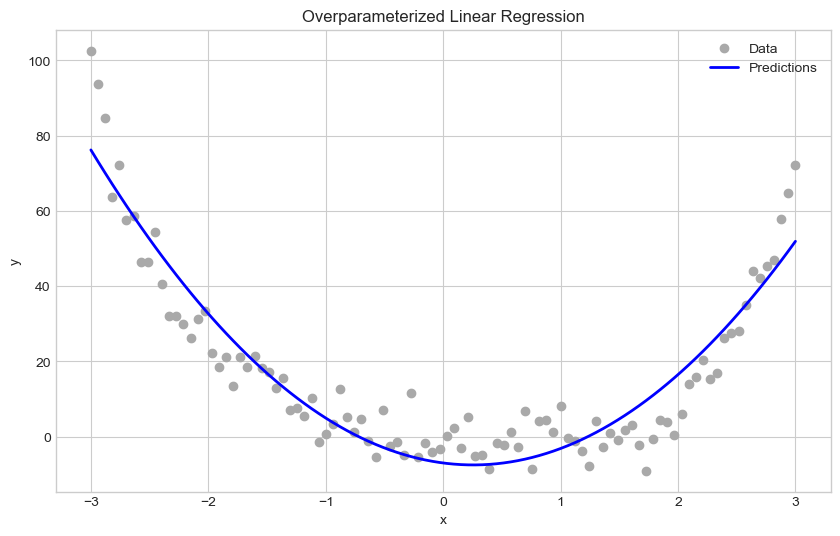

MSE loss: 66.9976


In [7]:
n_features = 10  # Number of random features

# Generate features
phi = RandomFeatures(n_features=n_features, activation=square)
phi.fit(X)
X_features = phi.transform(X)

# Train model
model = MyLinearRegression()
opt = OverParameterizedLinearRegressionOptimizer(model)
opt.fit(X_features, y.flatten())

# Predict and visualize
y_pred = model.predict(X_features)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='darkgrey', label='Data')
plt.plot(X.numpy(), y_pred.detach().numpy(), color='blue', linewidth=2, label='Predictions')
plt.title('Overparameterized Linear Regression')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(f"MSE loss: {model.loss(X_features, y.flatten()):.4f}")

## Part C: Double Descent In Image Corruption Detection

Now let's apply our model to a more complex real-world problem: predicting the number of corruptions in an image. First, we'll load a sample image and prepare it for processing. We'll use a flower image and convert it to grayscale for simplicity.

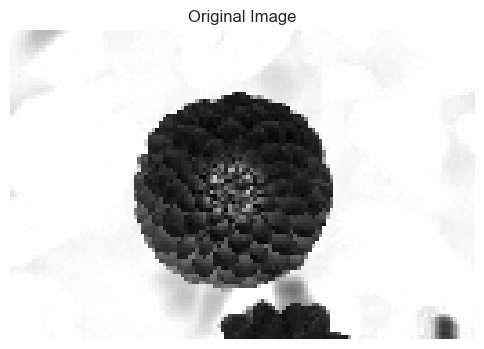

In [8]:
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom

# Load and prepare the image
dataset = load_sample_images()
X_img = dataset.images[1]  # Choose the flower image
X_img = zoom(X_img, 0.2)   # Reduce resolution
X_img = X_img.sum(axis=2)  # Convert to grayscale
X_img = X_img.max() - X_img  # Invert
X_img = X_img / X_img.max()  # Normalize
flower = torch.tensor(X_img, dtype=torch.float64)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(flower, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

To create our dataset, we need a function that adds random corruptions to our base image. Each corruption will be a small patch of altered pixels. The function will return both the corrupted image and the number of patches added, which will serve as our target variable for prediction.

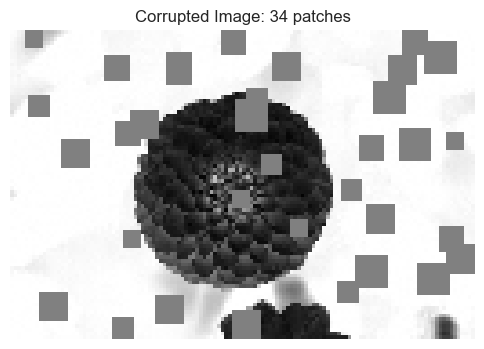

In [9]:
def corrupted_image(im, mean_patches=5):
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0
    X = im.clone()
    
    for _ in torch.arange(num_pixels_to_corrupt.item()):
        try:
            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))
            s = torch.randint(5, 10, (1,))
            patch = torch.zeros((s.item(), s.item()), dtype=torch.float64) + 0.5
            # Place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1
        except:
            pass
            
    return X, num_added

# Show an example of a corrupted image
X_corrupt, num_patches = corrupted_image(flower, mean_patches=50)
plt.figure(figsize=(6, 6))
plt.imshow(X_corrupt, cmap='gray', vmin=0, vmax=1)
plt.title(f"Corrupted Image: {num_patches} patches")
plt.axis('off')
plt.show()

With our corruption function ready, let's generate a dataset of corrupted images. For each sample, we'll add a random number of corruption patches to our base image and record the exact count. We'll then split this dataset into training and test sets to evaluate our model.

In [16]:
n_samples = 200
mean_patches = 100

X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype=torch.float64)
y = torch.zeros(n_samples, dtype=torch.float64)

for i in range(n_samples):
    X[i], y[i] = corrupted_image(flower, mean_patches=mean_patches)

# Reshape images for model input
X = X.reshape(n_samples, -1)  # Flatten each image

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

Now we come to the core of our experiment: evaluating how model performance changes with different numbers of features. The following function will train and test our model with varying feature counts, allowing us to observe the double descent phenomenon.

In [15]:
def evaluate_feature_count(n_features, X_train, y_train, X_test, y_test, activation=square):
    """Train and evaluate a model with n_features random features"""
    # Create feature map
    phi = RandomFeatures(n_features=n_features, activation=activation)
    phi.fit(X_train)
    
    # Transform data
    X_train_features = phi.transform(X_train)
    X_test_features = phi.transform(X_test)
    
    # Train model
    model = MyLinearRegression()
    opt = OverParameterizedLinearRegressionOptimizer(model)
    opt.fit(X_train_features, y_train)
    
    # Calculate training and testing errors
    train_mse = model.loss(X_train_features, y_train).item()
    test_mse = model.loss(X_test_features, y_test).item()
    
    return train_mse, test_mse

Let's set up a range of feature counts to evaluate, making sure to include values below, at, and above the number of training samples. This is crucial for observing the double descent curve. For each feature count, we'll record both training and test errors.

In [21]:
n_train = len(X_train)
feature_counts = np.unique(np.concatenate([
    np.linspace(5, n_train - 10, 25, dtype=int),
    np.linspace(n_train - 5, n_train + 5, 10, dtype=int),
    np.linspace(n_train + 10, 200, 15, dtype=int)
]))

# Evaluate each feature count
train_errors = []
test_errors = []

for n_feat in feature_counts:
    train_mse, test_mse = evaluate_feature_count(n_feat, X_train, y_train, X_test, y_test)
    train_errors.append(train_mse)
    test_errors.append(test_mse)

# Find the feature count with the best test performance
best_idx = np.argmin(test_errors)
best_n_features = feature_counts[best_idx]
best_test_error = test_errors[best_idx]

print(f"\nBest performance achieved with {best_n_features} features.")
print(f"Best test MSE: {best_test_error:.4f}")
print(f"Interpolation threshold: {n_train} (number of training samples)")


Best performance achieved with 167 features.
Best test MSE: 444.2678
Interpolation threshold: 100 (number of training samples)


Now that we've collected our results, let's visualize them to better understand the double descent phenomenon. We'll create two plots: one for training error and one for test error, both as functions of the number of features. The vertical line marks the interpolation threshold where the number of features equals the number of training samples.

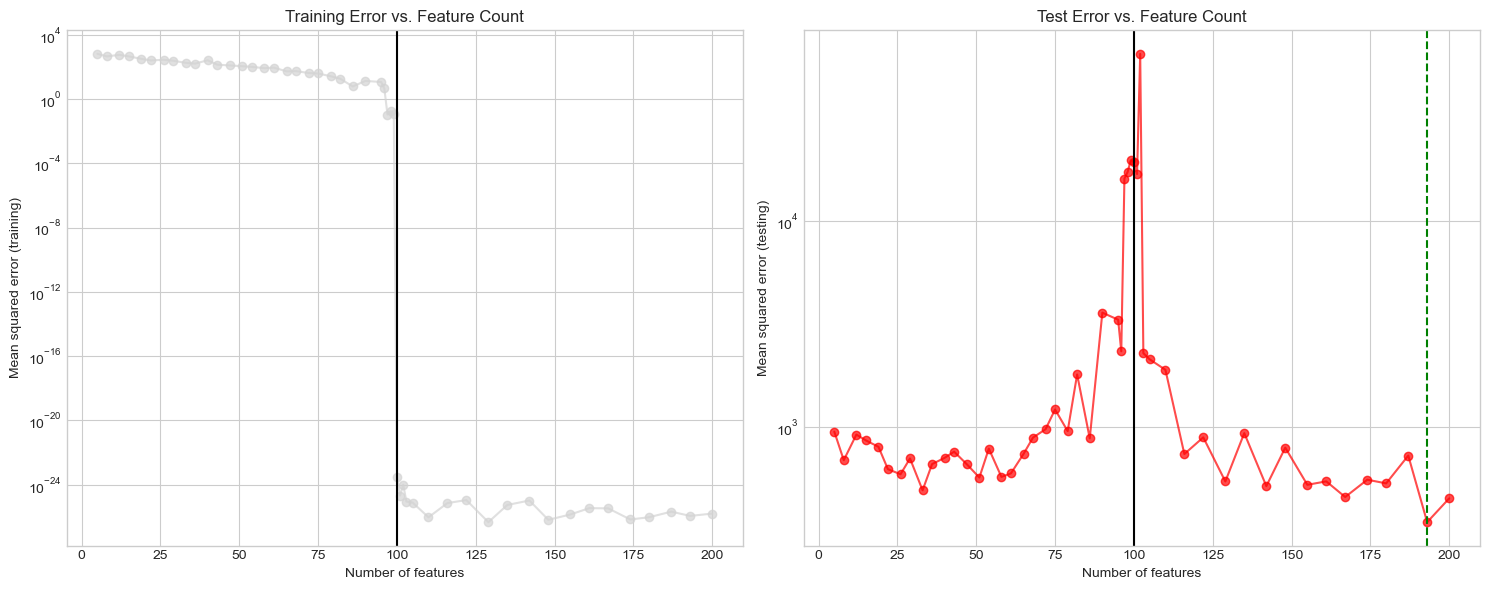

In [19]:
plt.figure(figsize=(15, 6))

# Training error plot
plt.subplot(1, 2, 1)
plt.semilogy(feature_counts, train_errors, 'o-', color='lightgray', alpha=0.7)
plt.axvline(x=n_train, color='black', linestyle='-')
plt.xlabel('Number of features')
plt.ylabel('Mean squared error (training)')
plt.title('Training Error vs. Feature Count')
plt.grid(True)

# Test error plot
plt.subplot(1, 2, 2)
plt.semilogy(feature_counts, test_errors, 'o-', color='red', alpha=0.7)
plt.axvline(x=n_train, color='black', linestyle='-')
plt.axvline(x=best_n_features, color='green', linestyle='--')
plt.xlabel('Number of features')
plt.ylabel('Mean squared error (testing)')
plt.title('Test Error vs. Feature Count')
plt.grid(True)

plt.tight_layout()
plt.show()

## Discussion

The plots above demonstrate the double descent phenomenon in our image corruption detection task. Here's what we observe:

1. **Training Error**: As expected, the training error decreases as we increase the number of features, eventually reaching near-zero when we have enough features to perfectly interpolate the training data.

2. **Test Error**: The test error shows a more complex pattern:
   - Initially, it decreases as we add more features and the model becomes more expressive
   - It then increases as we approach the interpolation threshold (where #features ≈ #training samples), which is the classical overfitting regime
   - Surprisingly, after passing the interpolation threshold, the test error decreases again - this is the "double descent" phenomenon

This challenges the classical view of the bias-variance tradeoff and suggests that highly overparameterized models can generalize well despite having enough capacity to perfectly fit the training data. This phenomenon helps explain why modern deep learning models with billions of parameters can achieve impressive results without catastrophic overfitting.

My optimal feature count was 167, which was above the interpolation threshold.